Given a state $s$, the policy $\pi$ determines the possible actions we can take.

$$ \pi\left(a\middle|s\right) $$

In [1]:
def eqr_policy(s):
    """Equiprobable random policy.
    Returns a list of (action_index, probability) tuples.
    Note that s is unused since this is random policy
    """
    return [
        (0, 0.25),
        (1, 0.25),
        (2, 0.25),
        (3, 0.25),
    ]

How to represent the dynamics?

$$ p\left(s',r\middle|s,a\right) $$

In [21]:
# 0: up, 1: right, 2: down, 3: left


def dynamics(s, a):
    """Dynamics for the gridworld environment.
    Given (s,a), return a list of (s', r, p), possible outcomes.
    """
    if s == 1: # one of the special states
        return [(21, +10, 1.0)]
    elif s == 3: # other special state
        return [(13, +5, 1.0)]
    # else we are not in the special states

    if a == 0: # moving up
        if s < 5: # hit top boundary, stay in place
            return [
                (s, -1, 1.0),
            ]
        else: # we are not at the top row
            return [
                (s - 5, 0, 1.0)
            ]
    elif a == 1: # moving right
        if (s+1) % 5 == 0: # hit right boundary
            return [
                (s, -1, 1.0)
            ]
        else: # we are not in the right row
            return [
                (s+1, 0, 1.0),
                ]
        
    elif a == 2: # moving down
        if s >= 20: # hit bottom boundary
            return [
                (s, -1, 1.0)
                ]
        else: # we are not in the bottom row
            return [
                (s + 5, 0, 1.0)
                ]
        
    elif a == 3: # moving left
        if s % 5 == 0: # hit left boundary
            return [
                (s, -1, 1.0)
            ]
        else: # not in leftmost row
            return [
                (s - 1, 0, 1.0)
            ]

Compute the value function by solving the linear system.

In [64]:
import numpy as np

A = np.zeros((25, 25)) # 25 possible states
b = np.zeros((25, 1))

gamma = 0.9

for s in range(25):
    for a, p_a_s in eqr_policy(s):
        for sp, r, p_spr in dynamics(s, a): # (s,r,p)
            # linear term
            b[s] += p_a_s * p_spr * r
            # coefficient matrix term
            A[s, sp] += p_a_s * p_spr

A_t = gamma * A - np.eye(25)
V = np.linalg.solve(A_t, -b).reshape((5,5))

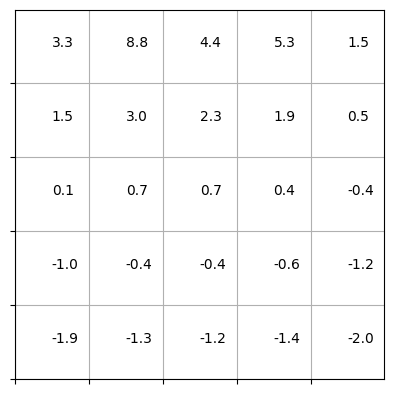

In [67]:
import matplotlib.pyplot as plt

def plot_v(v: np.ndarray, ax = None):
    if ax is None:
        _, ax = plt.subplots()

    ax.set(xlim=[-0.5,4.5], ylim=[-0.5,4.5])
    ax.set_xticks(np.arange(-0.5, 4.5, 1))
    ax.set_yticks(np.arange(-0.5, 4.5, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid()

    
    def state_to_txt_coord(s: int):
        y_coord = 5 - ( s // 5) - 1
        x_coord = s % 5
        return x_coord, y_coord

    for s in range(len(v)):
        x_t, y_t = state_to_txt_coord(s)
        ax.text(x=x_t, y=y_t, s=f"{v[s]:.1f}")
    ax.set_aspect('equal')
    # plt.show()

plot_v(V.flatten())

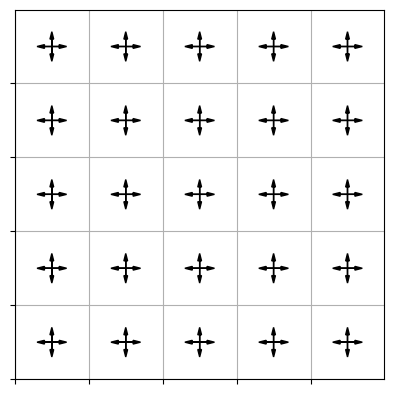

In [70]:
from typing import Callable

def plot_gridworld_policy(policy: Callable, ax = None):
    if ax is None:
        _, ax = plt.subplots()

    ax.set(xlim=[-0.5,4.5], ylim=[-0.5,4.5])
    ax.set_xticks(np.arange(-0.5, 4.5, 1))
    ax.set_yticks(np.arange(-0.5, 4.5, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid()

    def state_to_txt_coord(s: int):
        y_coord = 5 - ( s // 5) - 1
        x_coord = s % 5
        return x_coord, y_coord

    arrows = {0: [0,1], 1: [1, 0], 2: [0, -1], 3: [-1, 0]}
    scale = 0.40
    eps = 1e-5
    for s in range(25):
        x_t, y_t = state_to_txt_coord(s)
        for a, p_a_s in policy(s):
            arrow = np.array(arrows[a])
            arrow = scale * p_a_s * arrow
            if any(abs(arrow) > eps):
                ax.arrow(
                    x_t,
                    y_t,
                    arrow[0],
                    arrow[1],
                    head_width=0.05,
                    head_length=0.1,
                    fc='k',
                    ec='k',
                    )
    ax.set_aspect('equal')
    # plt.show()

plot_gridworld_policy(eqr_policy)

Let's solve the Bellman optimality equations to determine the optimal state value function $v_*$ given by the recursive relation $$ v_*\left(s\right) = \max_a \sum_{s',r} p\left(s',r\middle|s,a\right) \left(r + \gamma v_*\left(s'\right)\right) $$

This is a system of nonlinear equations, and we can use `sympy` to set it up and solve it.

In [74]:
import sympy
from sympy.functions.elementary.miscellaneous import Max

gamma = sympy.S(0.9)

states = list(range(25)) # linearized list of state indices
actions = list(range(4))

symbols = [ sympy.Symbol(f"v({s})", real=True) for s in states ]

equations = []
for s in states:

    a_terms = [] # collect terms for this state's equation, for each possible action a
    for a in actions:
        a_term = sympy.S(0) # init to zero
        for sp, r, p_spr in dynamics(s, a): # (s,r,p)
            a_term += sympy.S(p_spr) * (r + gamma * symbols[sp])
        a_terms.append(a_term)
    
    # take the max over all a
    eqn = symbols[s] - Max(*a_terms)
    equations.append(eqn)


In [79]:
soln = sympy.nsolve(equations, symbols, [1]*25)
v_star = np.array(soln).reshape((5,5))

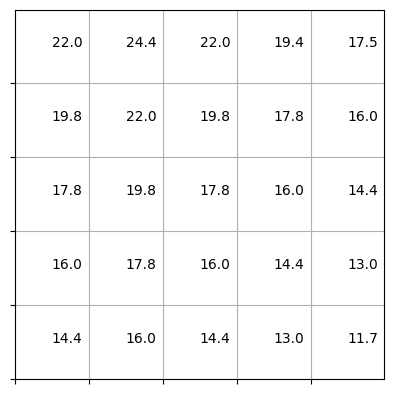

In [82]:
plot_v(v_star.flatten())

In [84]:
v_star

array([[21.9774852872946, 24.4194280969940, 21.9774852872946,
        19.4194280969940, 17.4774852872946],
       [19.7797367585651, 21.9774852872946, 19.7797367585651,
        17.8017630827086, 16.0215867744377],
       [17.8017630827086, 19.7797367585651, 17.8017630827086,
        16.0215867744377, 14.4194280969940],
       [16.0215867744377, 17.8017630827086, 16.0215867744377,
        14.4194280969940, 12.9774852872946],
       [14.4194280969940, 16.0215867744377, 14.4194280969940,
        12.9774852872946, 11.6797367585651]], dtype=object)

In [108]:
# obtain an optimal policy from v_*
def get_optimal_policy_from_v_star(v_star):

    def optimal_policy(s):
        # for each possible action, compute the quantity in the Bellman optimality equation
        exp_return_a = np.zeros(4) # four possible actions

        for a in range(4):
            for sp, r, p_spr in dynamics(s, a): # (sp,r,p)
                exp_return_a[a] += p_spr * (r + gamma * v_star.flatten()[sp])

        # then take the max
        optimal_actions = np.where(exp_return_a == np.max(exp_return_a))[0]
        p_ = 1/len(optimal_actions)
        return [(oa, p_) for oa in optimal_actions]
    return optimal_policy

policy_opt = get_optimal_policy_from_v_star(v_star)



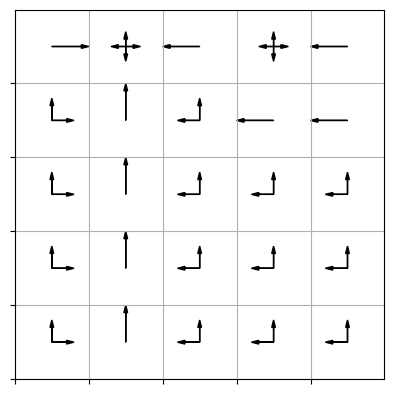

In [113]:
plot_gridworld_policy(policy_opt)

#### Get $q_*\left(s,a\right)$ from $v_*\left(s\right)$

In [115]:
v_star.shape

(5, 5)

In [123]:
r

-1

In [126]:
gamma = 0.9
v_star_f = v_star.flatten()
q_star = np.zeros((25, 4))

for s in states:
    for a in actions:
        for sp, r, p_sp_r in dynamics(s, a):
            q_star[s, a] += (r + gamma * v_star_f[sp]) * p_sp_r

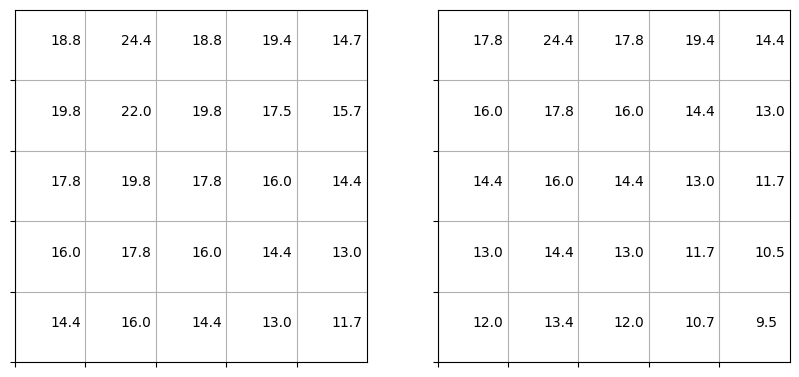

In [133]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
plot_v(q_star[:,0].flatten(), ax[0])
plot_v(q_star[:,2].flatten(), ax[1])

Given $q_*\left(s,a\right)$, it's easy to get an optimal policy: when in state $s$, pick $a$ that maximizes $q_*\left(s,\cdot\right)$.

In [136]:
def get_optimal_policy_from_q_star(q_star):

    def optimal_policy(s):
        exp_return_a = [q_star[s, a] for a in range(4)]

        # then take the max
        optimal_actions = np.where(exp_return_a == np.max(exp_return_a))[0]
        p_ = 1/len(optimal_actions)
        return [(oa, p_) for oa in optimal_actions]
    return optimal_policy

policy_opt = get_optimal_policy_from_q_star(q_star)



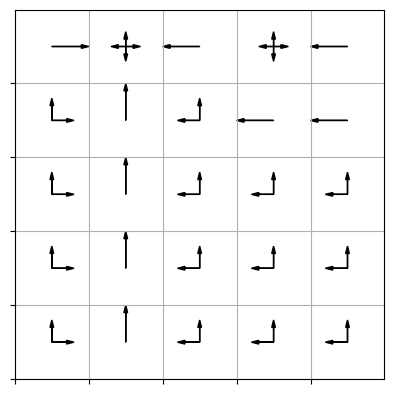

In [137]:
plot_gridworld_policy(policy_opt)

### Exercise 3.24

For the gridworld example, the optimal value of the best state, state $1$, is $24.4$. "Optimal value" is the value obtained by acting in accordance with an optimal policy, which we can see involves traversing the grid as $1 -> 21 -> 16 -> 11 -> 6 -> 1$, with corresponding rewards $10,0,0,0,0$. Thus, working backward from knowing this optimal policy, we have 

$$\begin{align*} G_{t+1} & = 10 + 0\gamma + 0\gamma^2 + 0\gamma^3 + 0\gamma^4 + 10 \gamma^5 + \cdots \\ & = 10 \left(1 + \gamma^5 + \gamma^{10} + \gamma^{15} + \cdots\right) \\ & = 10 \sum_{k=0}^{\infty} \left(\gamma^5\right)^k \\ & = \frac{10}{1 - \gamma^5} \\ & \approx 24.419 \end{align*} $$